- This notebook will plot all non-neuronal cells types(at Group level) for each samples separately and proportion of cell types

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import anndata 
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi = 180, dpi_save = 300, frameon = False, figsize = (4,4), fontsize=8,facecolor = 'white')



- Utility function for spatial plotting

In [2]:
def plot_cluster_scdata(scdata,cmap,all_clusters,clusters=[1,2],bg_color = 'gray',bg_pt_size = 5, point_sz_map = None, transpose=1,flipx=1,flipy=1,hue_input = 'leiden' , ax = None,use_seaborn = False,show_title = True):
    """
    plot spatial location of cell cluster using either seaborn or matplotlib
    use seaborn for individual clusters
    use matplotlib scatter function to visualize all clusters
    cmap - dictionary that has color of each cluster  used in umap
    """
    fig = None
    if not ax:
     fig,ax = plt.subplots(figsize=(15, 15),)# facecolor="black")

    
    if use_seaborn:
        x,y,hue = 'x', 'y',hue_input
        sns.scatterplot(x=x, y=y, data=scdata.obs, 
                        s=bg_pt_size, markers=dict(marker_edge_color='none'),
                        rasterized=True,
                        ax=ax,c= bg_color)
    else: # use matplotlib
        x,y = (np.array(scdata.obs[['x', 'y']])*[flipx,flipy])[:,::transpose].T
        ax.scatter(x, y, c=bg_color, s = bg_pt_size, marker='.')
        
    for cluster in clusters:
        clst_idx = all_clusters.index(cluster)
        cluster_ = str(cluster)
        inds = scdata.obs[hue_input] == cluster_
        
        #col = cmap[int(clst_idx) % len(cmap)]
        col = cmap[cluster_] # cmap is dictionary
        point_sz = point_sz_map[cluster_] # point size dictionary
        if use_seaborn:
            sns.scatterplot(x=x, y=y, data=scdata.obs[inds], 
                        s=point_sz, markers=dict(marker_edge_color=col),
                        rasterized=True,
                        ax=ax,c= col)
            if show_title:
                ax.set_title(f'cluster {cluster_}',fontsize = 7, y= 1)
        else:
            x_ = x[inds]
            y_ = y[inds]
            ax.scatter(x_, y_, c=col, s= point_sz, marker='.',label = cluster_)
        
        
    
    # ax.set_xlim([x.min(),x.max()])
    # ax.set_ylim([y.min(),y.max()])
    ax.grid(False)
    ax.axis("off")
    ax.axis("equal")
    if fig:
        ax.legend( loc = 'lower center', ncol = len(clusters)//3,markerscale = 12, title = 'Clusters',facecolor = 'black',
            labelcolor = 'white')
        ax.set_title(np.unique(scdata.obs['sample'])[0])
    else:
        # ax.legend( loc = 'lower center')
        pass
        
    ax.autoscale(enable=True, tight=True)
    
   

In [3]:
def rotate(spatial_x,deg):
    """
    spatial_X: Nx2 matrix
    deg: rotation degree in radian
    
    """
    deg = np.deg2rad(deg)
    rotation_mat = np.array([[np.cos(deg),-1*np.sin(deg)],
                            [np.sin(deg),np.cos(deg)]])
    return np.matmul(spatial_x,rotation_mat)

- Load all MERFISH data

In [ ]:
%%time

# load 1311 posterior 
Donor_1311_posterior_adata  = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER2_Gpe_Gpi_CaPu_1311__MERFISH_annotated.h5ad')
print('load 1311 posterior .....')

# # load 2427 posterior 
Donor_2427_posterior_adata = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER4_Gpe_Gpi_2724__MERFISH_annotated.h5ad')
print('load 2427 posterior .....')

# # load 2427 anterior 
Donor_2427_anterior_adata = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER1_CaPuNAC_2427__MERFISH_annotated.h5ad')
print('load 2427 anterior .....')

# # load 3924 anterior 
Donor_3924_anterior_adata = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER5_CaPuNAc_3924__MERFISH_annotated.h5ad')
print('load 3924 anterior  .....')

load 1311 posterior .....
load 2427 posterior .....
load 2427 anterior .....
load 3924 anterior  .....
CPU times: user 1min 17s, sys: 15.3 s, total: 1min 32s
Wall time: 1min 35s


- Concatenate the data

- Make sure the same order of genes is used in all samples and replace count with raw counts 

In [5]:
# make sure the same order of genes is used in all samples  and replace count with raw counts
common_gns = np.array(Donor_2427_posterior_adata.var_names)
Donor_1311_posterior_adata.X = Donor_1311_posterior_adata.layers['X_raw']
Donor_1311_posterior_adata = Donor_1311_posterior_adata[:,common_gns].copy()
Donor_1311_posterior_adata.obsm['X_spatial'] = Donor_1311_posterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_1311_posterior_adata.obsm else Donor_1311_posterior_adata.obsm['X_spatial']

Donor_2427_posterior_adata.X = Donor_2427_posterior_adata.layers['X_raw']
Donor_2427_posterior_adata = Donor_2427_posterior_adata[:,common_gns].copy()
Donor_2427_posterior_adata.obsm['X_spatial'] = Donor_2427_posterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_2427_posterior_adata.obsm else Donor_2427_posterior_adata.obsm['X_spatial']

Donor_2427_anterior_adata.X = Donor_2427_anterior_adata.obsm['X_raw']
Donor_2427_anterior_adata = Donor_2427_anterior_adata[:,common_gns].copy()
Donor_2427_anterior_adata.obsm['X_spatial'] = Donor_2427_anterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_2427_anterior_adata.obsm else Donor_2427_anterior_adata.obsm['X_spatial']

Donor_3924_anterior_adata.X = Donor_3924_anterior_adata.layers['X_raw']
Donor_3924_anterior_adata = Donor_3924_anterior_adata[:,common_gns].copy()
Donor_3924_anterior_adata.obsm['X_spatial'] = Donor_3924_anterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_3924_anterior_adata.obsm else Donor_3924_anterior_adata.obsm['X_spatial']

In [6]:
# concatenate the data
adata_MERFISH = anndata.concat([Donor_1311_posterior_adata,Donor_2427_posterior_adata,Donor_2427_anterior_adata,Donor_3924_anterior_adata],
                       label = 'samples',
                        keys= ['Donor_1311_posterior','Donor_2724_posterior','Donor_2724_anterior','Donor_3924_anterior'],
                        fill_value=0,
                        join='outer',
                        merge='same' ,
                        index_unique='_' # make the cell index unique
                        ) 


- Load the contour for the spatial modules 

In [ ]:
donor_1311_posterior_spatialModuleContours = np.load(r'./../../spatialDomain_analysis/processed_data/donor_1311_PosteriorMERFISH/spatialModule_Contourcoord.npy',allow_pickle = True).item()
donor_1311_posterior_StriosomeContours = np.load(r'./../../spatialDomain_analysis/processed_data/donor_1311_PosteriorMERFISH/Striosome_Contourcoord.npy',allow_pickle = True).item()

donor_2427_posterior_spatialModuleContours = np.load(r'./../../spatialDomain_analysis/processed_data/donor_2724_PosteriorMERFISH/spatialModule_Contourcoord.npy',allow_pickle = True).item()
donor_2427_posterior_StriosomeContours = np.load(r'./../../spatialDomain_analysis/processed_data/donor_2724_PosteriorMERFISH/Striosome_Contourcoord.npy',allow_pickle = True).item()

donor_2427_anterior_spatialModuleContours = np.load(r'./../../spatialDomain_analysis/processed_data/chip5_AnteriorMERFISH/spatialModule_Contourcoord.npy',allow_pickle = True).item()
donor_2427_anterior_StriosomeContours = np.load(r'./../../spatialDomain_analysis/processed_data/chip5_AnteriorMERFISH/Striosome_Contourcoord.npy',allow_pickle = True).item()

donor_3924_anterior_spatialModuleContours = np.load(r'./../../spatialDomain_analysis/processed_data/donor_3924_AnteriorMERFISH/spatialModule_Contourcoord.npy',allow_pickle = True).item()
donor_3924_anterior_StriosomeContours = np.load(r'./../../spatialDomain_analysis/processed_data/donor_3924_AnteriorMERFISH/Striosome_Contourcoord.npy',allow_pickle = True).item()

- Define colormap and define point size 

In [ ]:
cluster_cmap = np.load(r'./cluster_cmap_final_updated_9172025.npy',allow_pickle=True).item()

In [9]:
all_clusters = np.unique(adata_MERFISH.obs['Group_name']).tolist()
clusters_curated = [ 

# +++++++++++++ Oligo +++++++++++++++++++++++
'ImOligo','Oligo OPALIN', 'Oligo PLEKHG1',
'COP',
'OPC',
 
# # glia (Astro-Ependy-Immune)
 'Astrocyte',
  'Ependymal',
  'ImAstro',
 'B cells',
 'BAM',
 'Endo',
'VLMC',
'Pericyte',
 'SMC',

# # # ++++++++++++++++ Gp cells  +++++++++++++++++++
 'GPe MEIS2-SOX6 GABA',
 'GPe SOX6-CTXND1 GABA',
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
 'GPi Core',
 'GPi Shell',
 'GPin-BF Cholinergic GABA',

# # +++++++++++++++++ MSN ++++++++++++++++++++++++++++++++
    'STR D1D2 Hybrid MSN',
    'STRd D2 StrioMat Hybrid MSN',
    'STRv D1 NUDAP MSN',
    'STRd D2 Striosome MSN',
    'STRd D2 Matrix MSN',
    'STRd D1 Striosome MSN',
    'STRd D1 Matrix MSN',
    'STRv D1 MSN',
    'STRv D2 MSN'
    

    ]

remaining_clusters  = list(set(all_clusters).difference(clusters_curated))

all_clusters = remaining_clusters + clusters_curated

In [10]:
point_sz_map = { 'Oligo OPALIN': 0.05,
                 'Oligo PLEKHG1': 0.2,
                  'COP':0.5,
                  'ImOligo':0.2,
                  'OPC': 0.5,
                'STR D1D2 Hybrid MSN': 2,
                'STRd D2 StrioMat Hybrid MSN': 2,
                'STRv D1 NUDAP MSN':2,
                 'STRd D2 Striosome MSN':2,
                 'STRd D1 Striosome MSN':2,
                 'STRd D2 Matrix MSN':2,
                 'STRd D1 Matrix MSN':2,
                 'STRv D1 MSN':2,
                 'STRv D2 MSN':2,
                  'GPi Core':4,
                  'GPi Shell':4,
                   'GPe SOX6-CTXND1 GABA':2,
                   'GPe MEIS2-SOX6 GABA':2,
                   'GPe-NDB-SI LHX6-LHX8-GBX1 GABA':2,
                    'GPin-BF Cholinergic GABA':2,
                   
                    # glia (Astro-Ependy-Immune)
                    'Astrocyte':0.2,
                    'Ependymal':0.2,
                    'ImAstro':0.2,
                    'B cells':0.2,
                    'BAM':0.2,
                    'Endo':0.2,
                    'VLMC': 1,
                     'Pericyte': 0.5,
                     'SMC': 1,
                     'Microglia':1

                    
                 }

point_sz_map.update({clst:2 for clst in remaining_clusters})

### 1. Spatial plot for each MERFISH sample

- Restrict to non-neuronal cells 

In [11]:
keep = adata_MERFISH.obs['Neighborhood_name'].isin(['Nonneuron'])
nonneuron_celltypes = np.unique(adata_MERFISH[keep].obs['Group_name'])
allnonNeuron_clusters = [clst for clst in all_clusters if clst in nonneuron_celltypes]

In [12]:
np.unique(adata_MERFISH.obs['samples'])

array(['Donor_1311_posterior', 'Donor_2724_anterior',
       'Donor_2724_posterior', 'Donor_3924_anterior'], dtype=object)

In [13]:
import seaborn as sns
import matplotlib.patches as patches
import os
rot_deg = {'Donor_1311_posterior':0, 'Donor_2724_anterior':-45,'Donor_2724_posterior':0,'Donor_3924_anterior':45} # rotation value for each sample 

adata_MERFISH.obs[['x','y']] = adata_MERFISH.obsm['X_spatial'].copy()
figsize_scale = 8e3

dx_list = []
dy_list = []
samples = np.unique(adata_MERFISH.obs['samples'])
for i,sample in enumerate(samples):
    cond = adata_MERFISH.obs['samples'] == sample
    # adjucent the spatial coordinate 
    X_sample = adata_MERFISH[cond].obsm['X_spatial'].copy()
    X_sample = rotate(X_sample,rot_deg[sample]) # since rotation is could change the xy limit, perform rotation to get accurate estiamte

    # idenity the proprotion betwen the width and height of the sample
    dx,dy = np.abs(np.ptp(X_sample, axis = 0))
    dx_list += [dx/figsize_scale]
    dy_list += [dy/figsize_scale]
dx_max = np.max(dx_list)  
dy_max = np.max(dy_list)  
print(f'max-width:{dx_max}, max-height:{dy_max}')

max-width:3.4967735624804646, max-height:4.602798834741115


In [14]:
all_clusters

['STR Cholinergic GABA',
 'AMY-SLEA-BNST GABA',
 'SN-VTR GAD2 Dopa',
 'BF SKOR1 Glut',
 'STR LYPD6-RSPO2 GABA',
 'STR SST-CHODL GABA',
 'VIP GABA',
 'STR SST-RSPO2 GABA',
 'Microglia',
 'Monocyte',
 'STH PVALB-PITX2 Glut',
 'SN-VTR CALB1 Dopa',
 'OB FRMD7 GABA',
 'SN SOX6 Dopa',
 'ZI-HTH GABA',
 'LAMP5-LHX6 GABA',
 'AMY-SLEA-BNST D1 GABA',
 'STR FS PTHLH-PVALB GABA',
 'SN SEMA5A GABA',
 'STR-BF TAC3-PLPP4-LHX8 GABA',
 'STR TAC3-PLPP4 GABA',
 'STRd Cholinergic GABA',
 'OB Dopa-GABA',
 'SN EBF2 GABA',
 'SN-VTR-HTH GATA3-TCF7L2 GABA',
 'LAMP5-CXCL14 GABA',
 'VTR-HTH Glut',
 'T cells',
 'SN GATA3-PVALB GABA',
 'OT D1 ICj',
 'STR SST-ADARB2 GABA',
 'ImOligo',
 'Oligo OPALIN',
 'Oligo PLEKHG1',
 'COP',
 'OPC',
 'Astrocyte',
 'Ependymal',
 'ImAstro',
 'B cells',
 'BAM',
 'Endo',
 'VLMC',
 'Pericyte',
 'SMC',
 'GPe MEIS2-SOX6 GABA',
 'GPe SOX6-CTXND1 GABA',
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
 'GPi Core',
 'GPi Shell',
 'GPin-BF Cholinergic GABA',
 'STR D1D2 Hybrid MSN',
 'STRd D2 StrioMat Hybr

In [ ]:
# define canvas for each samples, figure size will be based on the proprotion of the actual tissue size.

# fig,ax = plt.subplots(1,1,dpi = 300, figsize = (15,7))
import seaborn as sns
import matplotlib.patches as patches
import os
import copy 

rot_deg = {'Donor_1311_posterior':0, 'Donor_2724_anterior':-45,'Donor_2724_posterior':0,'Donor_3924_anterior':45} # rotation value for each sample 
reverse_coord = {'Donor_1311_posterior':False,'Donor_2724_anterior':True, 'Donor_2724_posterior':False,'Donor_3924_anterior':True }
invert_xaxis = {'Donor_1311_posterior':False,'Donor_2724_anterior':True,'Donor_2724_posterior':False,'Donor_3924_anterior':False }
invert_yaxis = {'Donor_1311_posterior':True,'Donor_2724_anterior':True,'Donor_2724_posterior':True,'Donor_3924_anterior':True}
backgd_sz = {'Donor_1311_posterior':0.002,'Donor_2724_anterior':0.002,'Donor_2724_posterior':0.002,'Donor_3924_anterior':0.002}
# spatial module dictionary
sptial_module_dict = {'Donor_1311_posterior':donor_1311_posterior_spatialModuleContours,'Donor_2724_anterior':donor_2427_anterior_spatialModuleContours,'Donor_2724_posterior':donor_2427_posterior_spatialModuleContours,'Donor_3924_anterior':donor_3924_anterior_spatialModuleContours}
Striosome_module_dict = {'Donor_1311_posterior':donor_1311_posterior_StriosomeContours,'Donor_2724_anterior':donor_2427_anterior_StriosomeContours,'Donor_2724_posterior':donor_2427_posterior_StriosomeContours,'Donor_3924_anterior':donor_3924_anterior_StriosomeContours}

# all_clusters_plot = ['GPe-NDB-SI LHX6-LHX8-GBX1 GABA', 'SN-VTR-HTH GATA3-TCF7L2 GABA','STR FS PTHLH-PVALB GABA', 'STR-BF TAC3-PLPP4-LHX8 GABA','STRd D2 StrioMat Hybrid MSN']
# all_clusters_plot = [ 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA','GPi Shell',]
for cluster_ in allnonNeuron_clusters:

    fig = plt.figure(dpi = 300, figsize = (dx_max,dy_max))
    bbox = fig.get_tightbbox()
    ax = None

    samples = ['Donor_3924_anterior','Donor_2724_anterior','Donor_2724_posterior','Donor_1311_posterior']
    # samples = ['Donor_2427_posterior','Donor_1311_posterior']
    figure_title = 'GPin_Cholin_posterior'
    for sampleIdx,sample in enumerate(samples):
        cond = adata_MERFISH.obs['samples'] == sample
        # adjucent the spatial coordinate 
        X_sample = adata_MERFISH[cond].obsm['X_spatial'].copy()
        X_sample = rotate(X_sample,rot_deg[sample])
        cnt = copy.deepcopy(sptial_module_dict[sample])
        strio_cnt = Striosome_module_dict[sample]['Striosome'].copy()
        
        for label_ in cnt:
            if isinstance(cnt[label_],list):
                for i in range(len(cnt[label_])):
                    cnt[label_][i] = rotate(cnt[label_][i],rot_deg[sample])
            else:   
                cnt[label_] = rotate(cnt[label_],rot_deg[sample])
        for idx in range(len(strio_cnt)):
            strio_cnt[idx] = rotate(strio_cnt[idx],rot_deg[sample])

        if reverse_coord[sample]:
            X_sample = X_sample[:,::-1]
            for label_ in cnt:
                if isinstance(cnt[label_],list):
                    for i in range(len(cnt[label_])):
                        cnt[label_][i] = cnt[label_][i][:,::-1]
                else:
                    cnt[label_] = cnt[label_][:,::-1]
            for idx in range(len(strio_cnt)):
                strio_cnt[idx] = strio_cnt[idx][:,::-1]

        adata_MERFISH.obs.loc[cond,['x','y']] = X_sample.copy()
        # idenity the proprotion betwen the width and height of the sample
        dx,dy = np.abs(np.ptp(X_sample, axis = 0))
        if ax != None:
            bbox = ax.get_position()
        dx = dx/figsize_scale
        dy = dy/figsize_scale
        # calculate fraction of the new x and y size as fraction of the previous axis x and y size. we are doing this because, fig.add_axes accept values as fraction of the figure width and hight, 
        dx_frac = dx/fig.get_figwidth()
        dy_frac = dy/fig.get_figheight()
        width_gap = 1
        if sampleIdx < 2:
            width_gap = 0.8
        #     point_sz_map[all_clusters_plot[0]] = 1
        #     point_sz_map[all_clusters_plot[1]] = 1
            # point_sz_map[all_clusters_plot[2]] = 1
        elif sampleIdx < 3:
            width_gap = 0.9

        ax = fig.add_axes([bbox.xmin + width_gap*bbox.width,bbox.ymin,dx_frac, dy_frac], adjustable = 'box')
        plot_cluster_scdata(adata_MERFISH[cond],cluster_cmap,all_clusters = [cluster_],clusters = [cluster_],bg_color = 'gray',bg_pt_size = backgd_sz[sample], point_sz_map = point_sz_map, transpose=1,flipx=1,flipy=1,hue_input = 'Group_name' , ax = ax,use_seaborn = True,show_title = False )

        # add the outregion outlines 
        for label_ in ['Caudate','Putamen','NAC_shell','NAC_core','Gpi','Gpe','Internal_Capsule','BNST','anterior_commissure','Thalamus','whitematter(Olfactory area)','IsCj']:
            if label_ in cnt:
                if isinstance(cnt[label_],list):
                    for i in range(len(cnt[label_])):
                        ax.plot(cnt[label_][i][:,0],cnt[label_][i][:,1], lw = 1, c = 'k')
                else:
                    ax.plot(cnt[label_][:,0],cnt[label_][:,1], lw = 1, c = 'k')
        # add the striosome contour outline
        # for cnt in strio_cnt:
        #     ax.scatter(cnt[:,0],cnt[:,1], s = 0.01, c = 'k')      

        # Set the axis limits 
        xmax, ymax = X_sample.max(axis=0)
        xmin, ymin = X_sample.min(axis=0)
        # ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax + 3500])
        # add scale bar
        if sample == 'Donor_2724_anterior':
            scalebar = patches.Rectangle([xmax - 500,1*ymax + 3000],-10000,200,color = 'k')
        else:    
            scalebar = patches.Rectangle([xmin + 500,1*ymax + 3000],10000,200,color = 'k')
        
        ax.add_patch(scalebar)

        if invert_xaxis[sample]:
            ax.invert_xaxis()
        
        if invert_yaxis[sample]:
            ax.invert_yaxis()
        # ax.set_aspect('equal', adjustable ='datalim')
        if sampleIdx == 0:
            ax.text(xmin + 0.7*np.ptp(X_sample[:,0]), ymin - 0.2*np.ptp(X_sample[:,1]), f'{cluster_}', fontsize = 25, color = 'k')
        #     ax.text(xmin + 0.2*np.ptp(X_sample[:,0]), ymin - 0.2*np.ptp(X_sample[:,1]), f'{figure_title}', fontsize = 25)

    file_name = '_'.join([x for x in f'{cluster_}'.replace(' ','_').split('-') ])
    plt.savefig(r'./figures/Figure4/supplemental/individual_spatial_maps' + os.sep + file_name + '.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/Figure4/supplemental/individual_spatial_maps' + os.sep + file_name + '.tif',bbox_inches = 'tight')

    plt.show()

### 2. Cell type proportion

In [56]:
adata_MERFISH.obs['Neighborhood_name'].unique()

['Subpallium GABA', 'Nonneuron', 'Glut Sero Dopa', 'Subpallium GABA-Glut']
Categories (4, object): ['Glut Sero Dopa', 'Nonneuron', 'Subpallium GABA', 'Subpallium GABA-Glut']

A. Proportion of all Non-Neurons(Major class)

In [13]:
class_map = {'Astro-Epen': "#E69F00",
 'CN CGE GABA': "#dc08f3",
 'CN LGE GABA': "#D55E00",
 'CN MGE GABA': "#56B4E9",
 'Cx GABA': '#469990',
 'F M GABA': '#000075',
 'F M Glut': '#3cb44b',
 'Immune': "#1227E1",
 'OPC-Oligo': "#009E73",
 'Vascular': "#CC79A7",
 'M Dopa': "#FF008C",
 'CN GABA-Glut': "#07FDE4"}

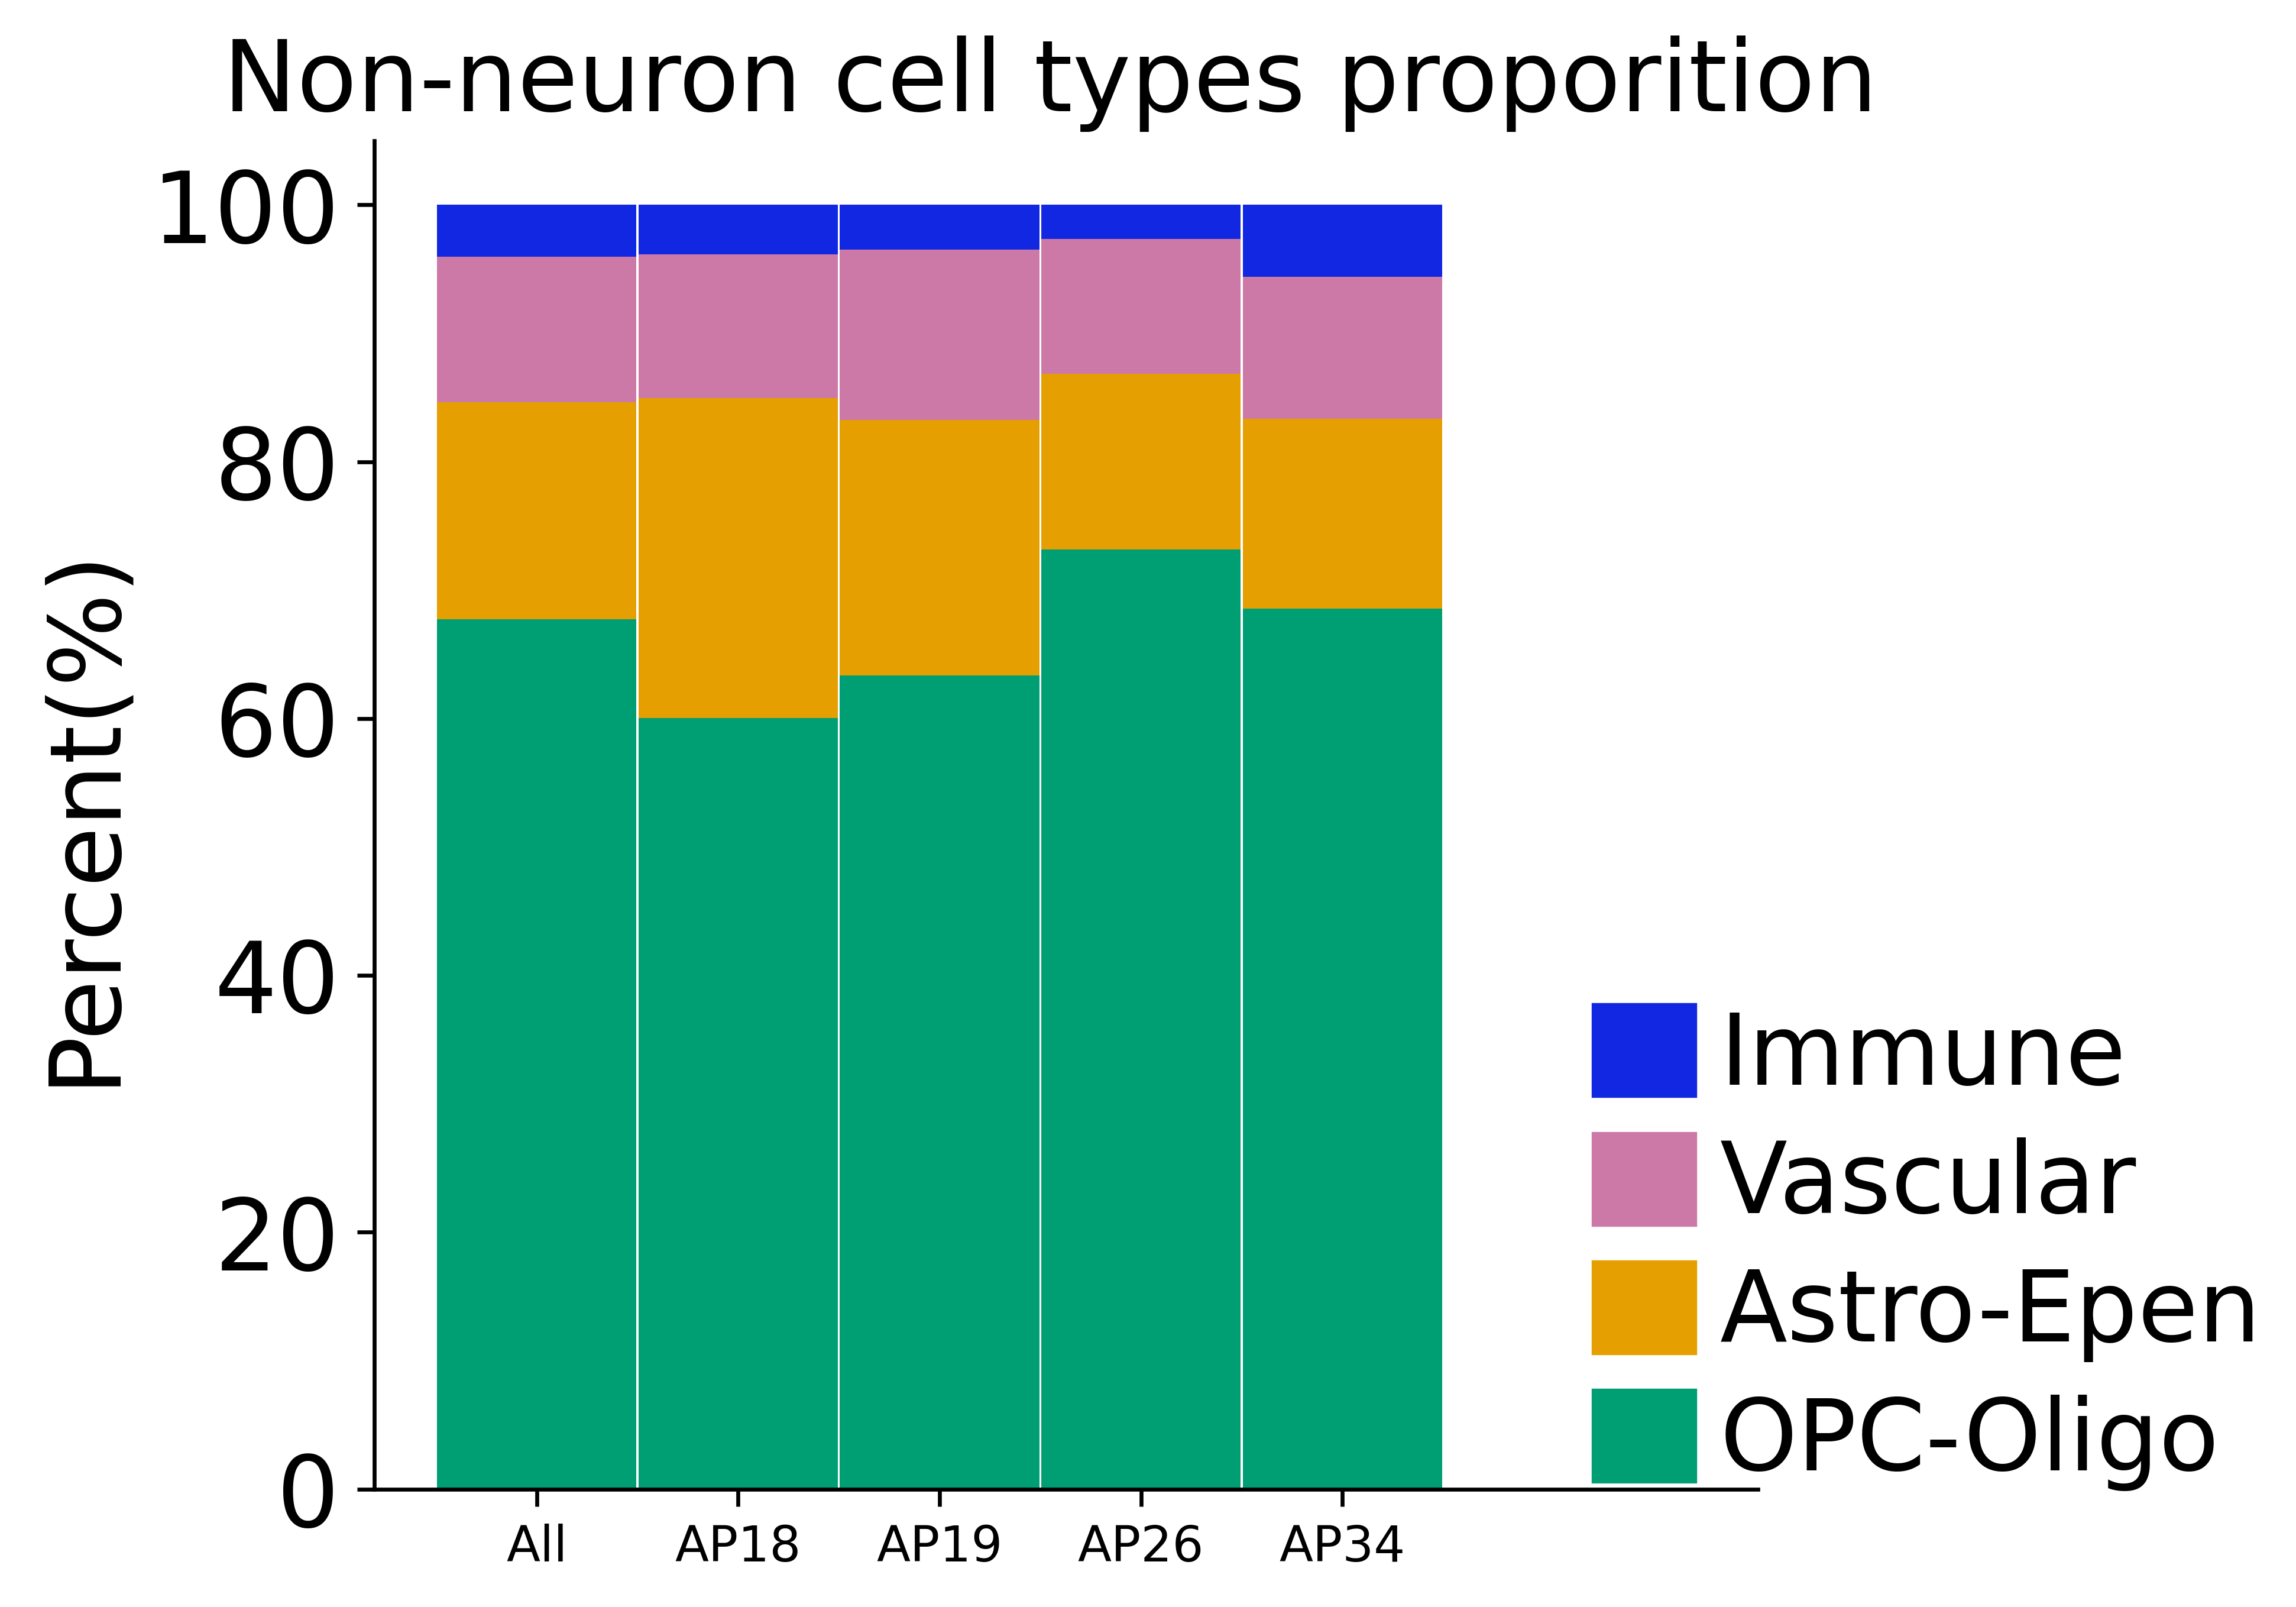

In [14]:
# first get the overall proporition
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
adata_obs = adata_MERFISH.obs.copy()
keepnonNeuron = adata_obs['Neighborhood_name'].isin(['Nonneuron'])
adata_obs = adata_obs[keepnonNeuron].copy()

# # remove unused cell types,
celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
for nm in celltype_cols:
    adata_obs[nm] = adata_obs[nm].astype(str)
    adata_obs[nm] = adata_obs[nm].astype('category')
nonNeuron_fraction = [adata_obs['Class_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':'All'})]

# then get the per sample proporition 
for sample in ['Donor_3924_anterior','Donor_2724_anterior','Donor_2724_posterior','Donor_1311_posterior']: #np.unique(adata_MERFISH.obs['samples']):

    adata_obs = adata_MERFISH[adata_MERFISH.obs['samples'] == sample].obs.copy()
    keepnonNeuron = adata_obs['Neighborhood_name'].isin(['Nonneuron'])
    adata_obs = adata_obs[keepnonNeuron].copy()
    
    # # remove unused cell types,
    celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
    for nm in celltype_cols:
        adata_obs[nm] = adata_obs[nm].astype(str)
        adata_obs[nm] = adata_obs[nm].astype('category')
    nonNeuron_fraction += [adata_obs['Class_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':sample})]

nonNeuron_fraction = pd.concat(nonNeuron_fraction,axis = 1)
nonNeuron_fraction = 100*nonNeuron_fraction

# stacked bar plot
import matplotlib.patches as patches
import os
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
bottom = np.zeros(nonNeuron_fraction.shape[-1])
width = 0.99
xlabels = [nonNeuron_fraction.columns[0]] + [x.split('_')[1] + x.split('_')[2][0] for x in nonNeuron_fraction.columns[1:]]
xlabel_mapper = {'3924a':'AP18','2724a':'AP19','2724p':'AP26','1311p':'AP34'}
xlabels = xlabels[:1] + [xlabel_mapper[nm] for nm in xlabels[1:]]

for idx,type_ in enumerate(nonNeuron_fraction.index):
    vals = nonNeuron_fraction.loc[type_,:].values
    ax.bar(xlabels,vals,width = width ,bottom = bottom, color =class_map[type_])
    bottom += vals

ax.grid(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.set_xticks([])
ax.set_ylabel('Percent(%)', fontdict={'fontsize': 20})

ax.tick_params('y',which='major',labelsize = 20)
ax.tick_params('x',which='major',labelsize = 10)
# add legend 
bbox = ax.get_position()
for i,type_ in enumerate(nonNeuron_fraction.index):
    rec = patches.Rectangle([bbox.xmin +  6.5*bbox.width , 0.7*bbox.ymax + i* 10] , 0.5,7, color = class_map[type_], )
    ax.add_patch(rec)

    # add label 
    ax.text(bbox.xmin +  7.3*bbox.width , (0.7*bbox.ymax + i* 10) + 3,type_,va = 'center')

ax.set_title(f'Non-neuron cell types proporition ', fontdict={'fontsize': 20})
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_MajorNonneuron_neuronCellType_proportion' + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_MajorNonneuron_neuronCellType_proportion' + '.tif',bbox_inches = 'tight')
plt.show()

B. Proportition of Oligo-OPC

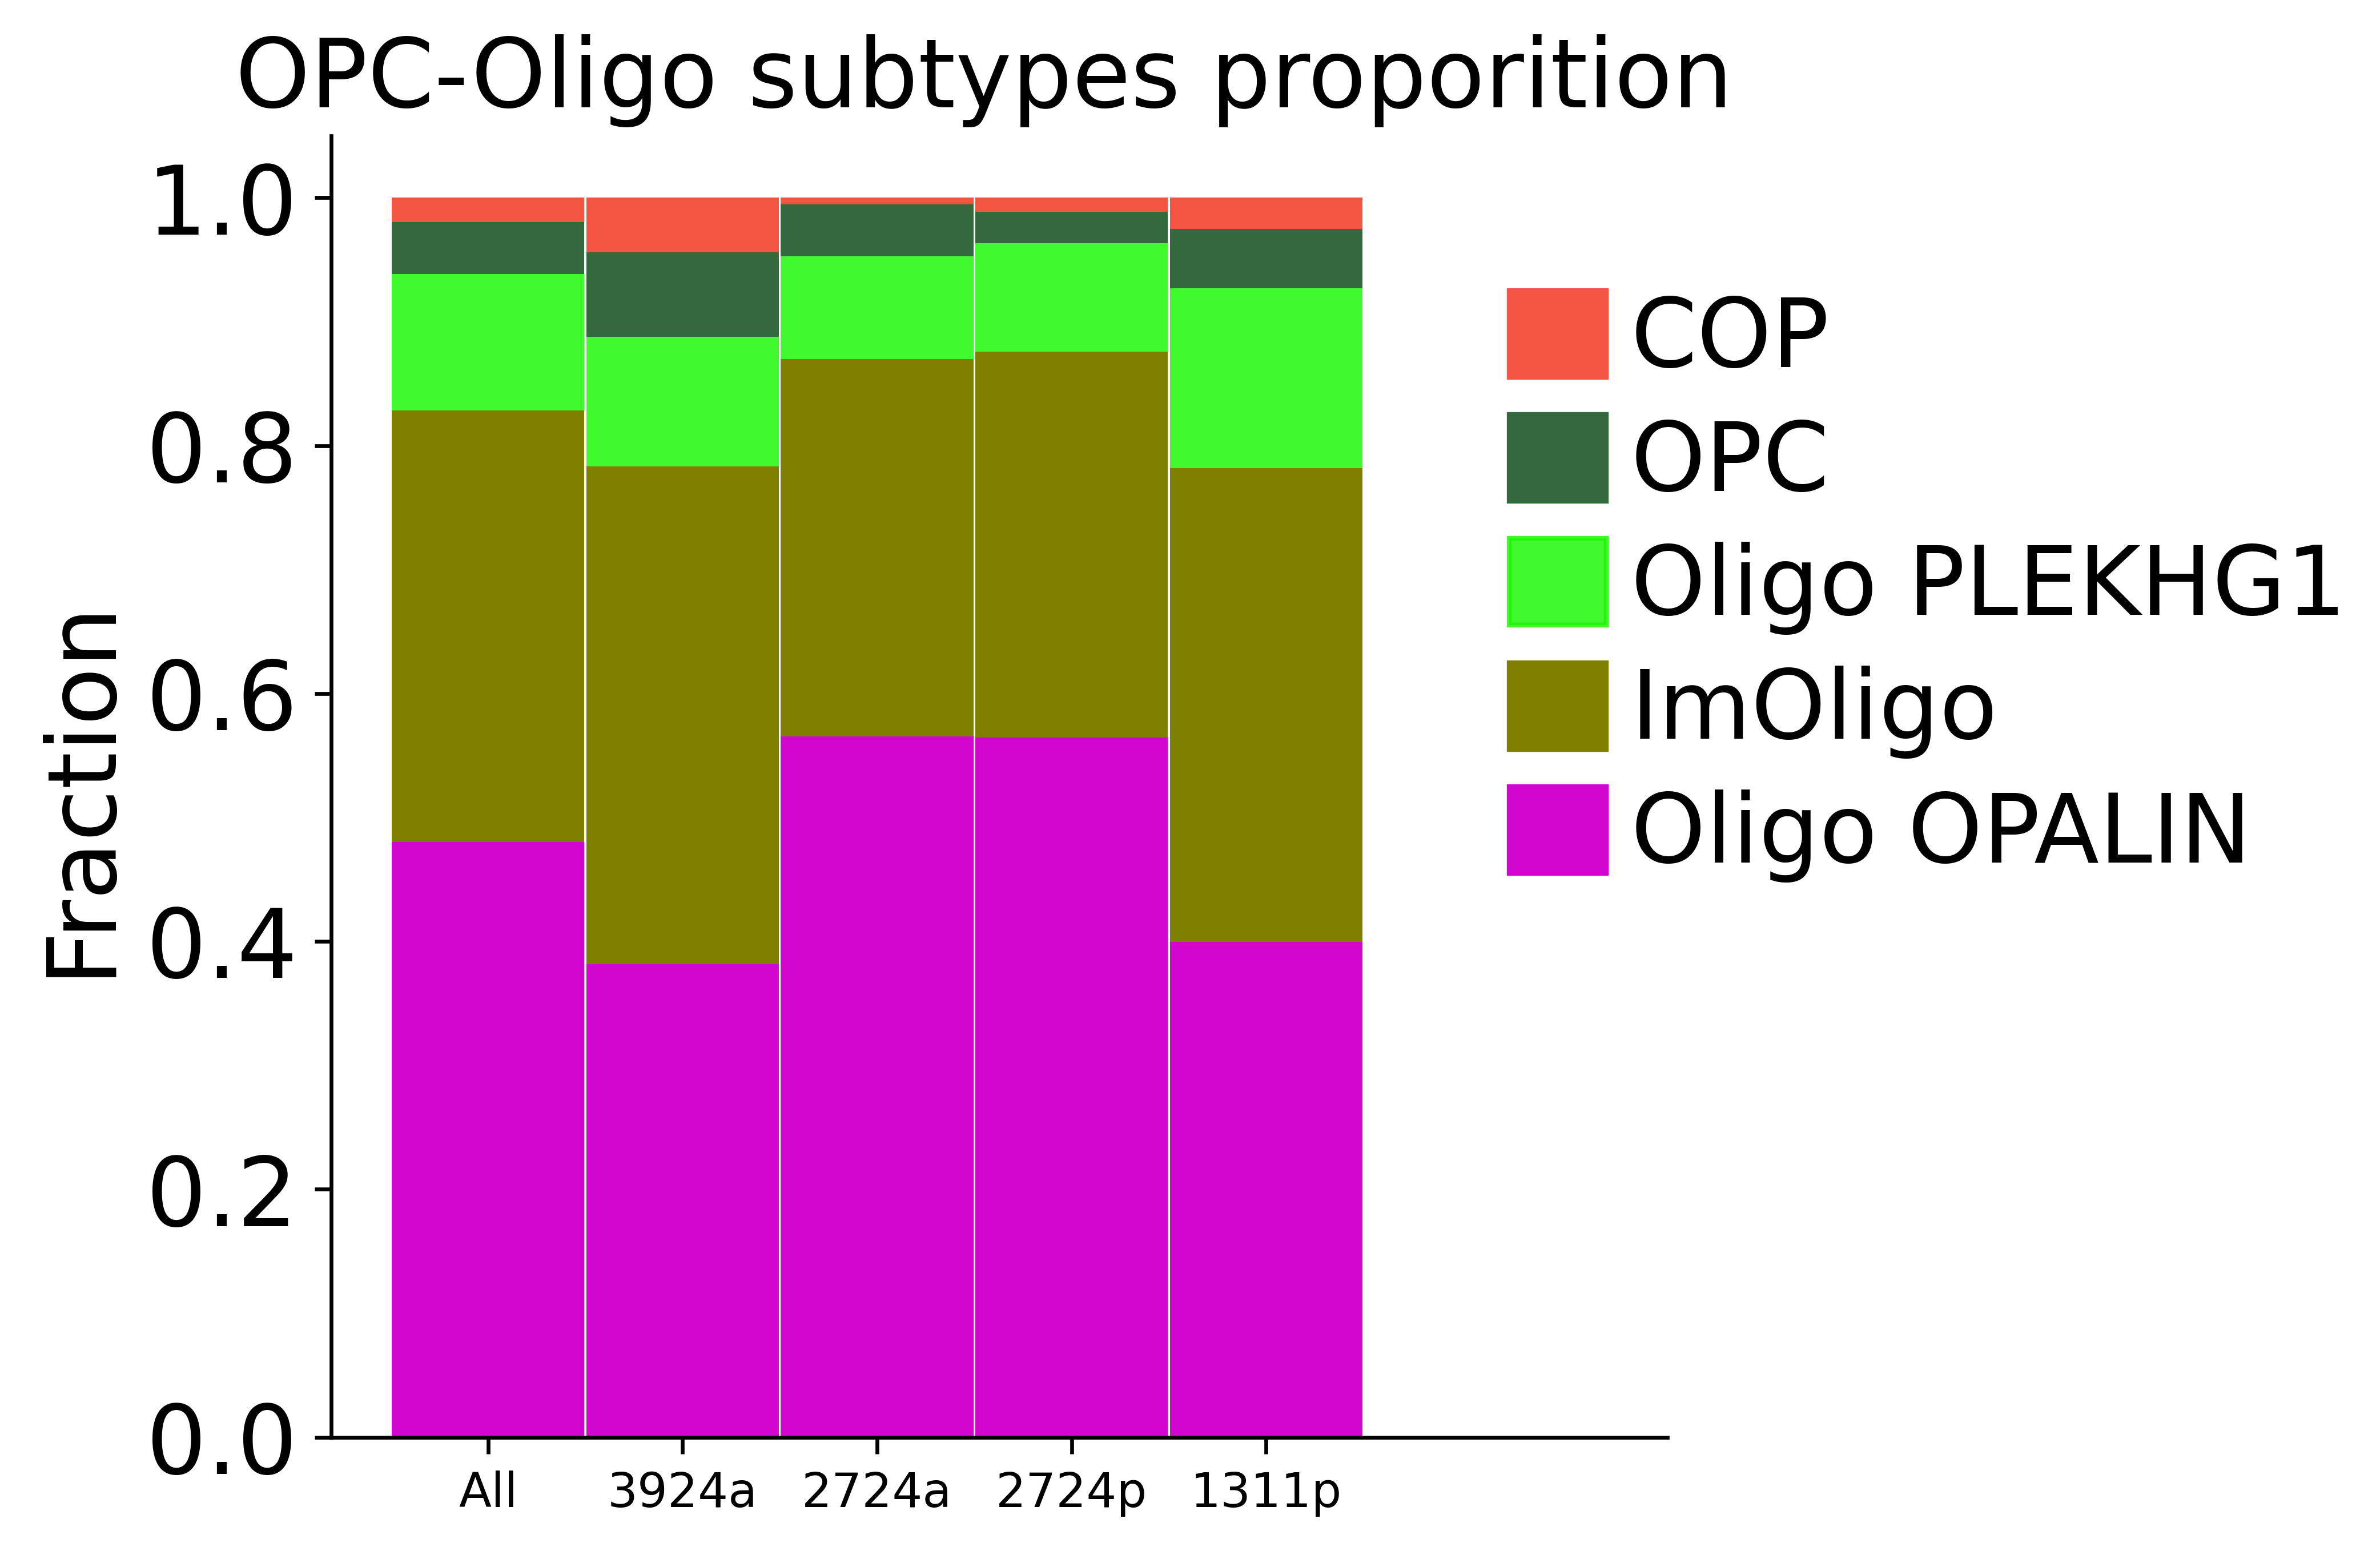

In [17]:
# first get the overall proporition
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
adata_obs = adata_MERFISH.obs.copy()
keeptype = adata_obs['Class_name'].isin(['OPC-Oligo'])
adata_obs = adata_obs[keeptype].copy()

# # remove unused cell types,
celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
for nm in celltype_cols:
    adata_obs[nm] = adata_obs[nm].astype(str)
    adata_obs[nm] = adata_obs[nm].astype('category')
oligo_fraction = [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':'All'})]

# then get the per sample proporition 
for sample in ['Donor_3924_anterior','Donor_2724_anterior','Donor_2724_posterior','Donor_1311_posterior']: #np.unique(adata_MERFISH.obs['samples']):

    adata_obs = adata_MERFISH[adata_MERFISH.obs['samples'] == sample].obs.copy()
    keeptype = adata_obs['Class_name'].isin(['OPC-Oligo'])
    adata_obs = adata_obs[keeptype].copy()
    
    # # remove unused cell types,
    celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
    for nm in celltype_cols:
        adata_obs[nm] = adata_obs[nm].astype(str)
        adata_obs[nm] = adata_obs[nm].astype('category')
    oligo_fraction += [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':sample})]

oligo_fraction = pd.concat(oligo_fraction,axis = 1)

# stacked bar plot
import matplotlib.patches as patches
import os
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
bottom = np.zeros(oligo_fraction.shape[-1])
width = 0.99
xlabels = [oligo_fraction.columns[0]] + [x.split('_')[1] + x.split('_')[2][0] for x in oligo_fraction.columns[1:]]

for idx,type_ in enumerate(oligo_fraction.index):
    vals = oligo_fraction.loc[type_,:].values
    ax.bar(xlabels,vals,width = width ,bottom = bottom, color =cluster_cmap[type_])
    bottom += vals

ax.grid(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.set_xticks([])
ax.set_ylabel('Fraction', fontdict={'fontsize': 20})

ax.tick_params('y',which='major',labelsize = 20)
ax.tick_params('x',which='major',labelsize = 10)
# add legend 
bbox = ax.get_position()
for i,type_ in enumerate(oligo_fraction.index):
    rec = patches.Rectangle([bbox.xmin +  6.5*bbox.width , 0.5*bbox.ymax + i* 0.1] , 0.5,0.07, color = cluster_cmap[type_], )
    ax.add_patch(rec)

    # add label 
    ax.text(bbox.xmin +  7.3*bbox.width , (0.5*bbox.ymax + i* 0.1) + 0.03,type_,va = 'center')

ax.set_title(f'OPC-Oligo subtypes proporition ', fontdict={'fontsize': 20})
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_MajorNonneuron_OligoCellType_proportion' + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_MajorNonneuron_OligoCellType_proportion' + '.tif',bbox_inches = 'tight')
plt.show()

C. Proportition of Astrocyte 

In [18]:
np.unique(adata_MERFISH.obs['Class_name'])

array(['Astro-Epen', 'CN CGE GABA', 'CN GABA-Glut', 'CN LGE GABA',
       'CN MGE GABA', 'Cx GABA', 'F M GABA', 'F M Glut', 'Immune',
       'M Dopa', 'OPC-Oligo', 'Vascular'], dtype=object)

/tmp/ipykernel_3573190/3015509764.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([np.round(100*y) for y in yticks])


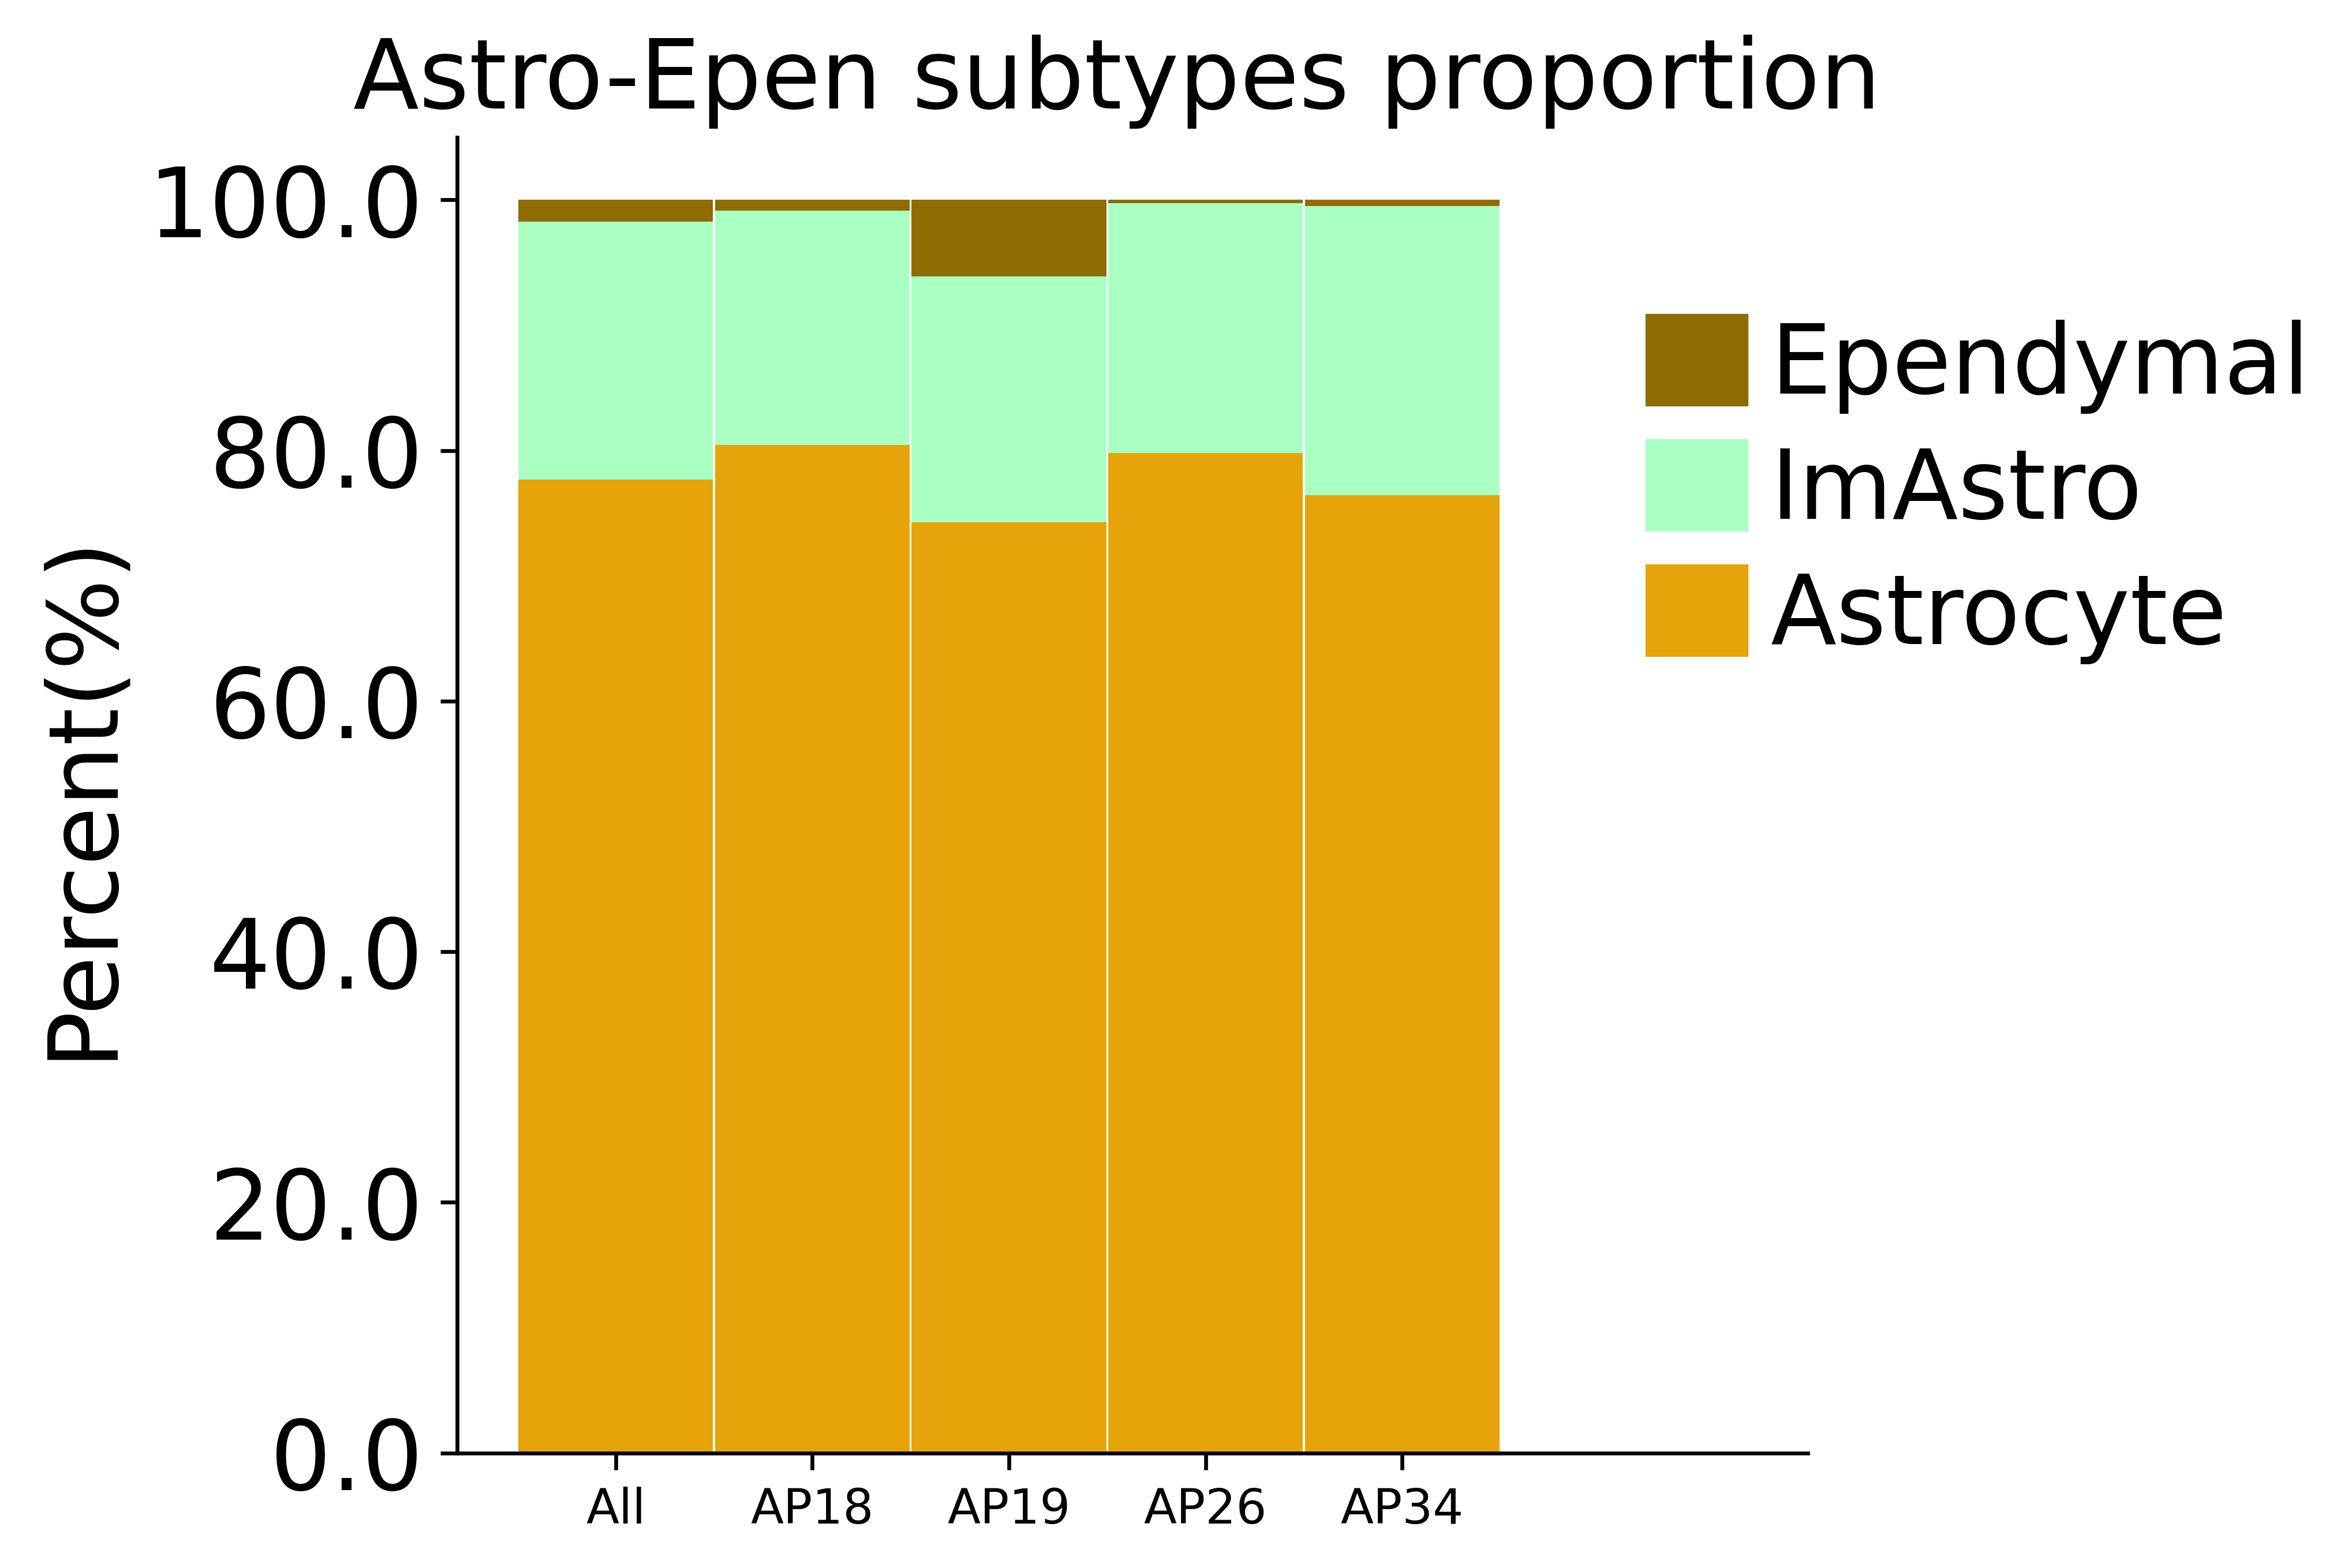

In [14]:
# first get the overall proporition
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
adata_obs = adata_MERFISH.obs.copy()
keeptype = adata_obs['Class_name'].isin(['Astro-Epen'])
adata_obs = adata_obs[keeptype].copy()

# # remove unused cell types,
celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
for nm in celltype_cols:
    adata_obs[nm] = adata_obs[nm].astype(str)
    adata_obs[nm] = adata_obs[nm].astype('category')
astro_fraction = [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':'All'})]

# then get the per sample proporition 
for sample in ['Donor_3924_anterior','Donor_2724_anterior','Donor_2724_posterior','Donor_1311_posterior']: #np.unique(adata_MERFISH.obs['samples']):

    adata_obs = adata_MERFISH[adata_MERFISH.obs['samples'] == sample].obs.copy()
    keeptype = adata_obs['Class_name'].isin(['Astro-Epen'])
    adata_obs = adata_obs[keeptype].copy()
    
    # # remove unused cell types,
    celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
    for nm in celltype_cols:
        adata_obs[nm] = adata_obs[nm].astype(str)
        adata_obs[nm] = adata_obs[nm].astype('category')
    astro_fraction += [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':sample})]

astro_fraction = pd.concat(astro_fraction,axis = 1)

# stacked bar plot
import matplotlib.patches as patches
import os
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
bottom = np.zeros(astro_fraction.shape[-1])
width = 0.99
xlabels = [astro_fraction.columns[0]] + [x.split('_')[1] + x.split('_')[2][0] for x in astro_fraction.columns[1:]]
xlabel_mapper = {'3924a':'AP18','2724a':'AP19','2724p':'AP26','1311p':'AP34'}
xlabels = xlabels[:1] + [xlabel_mapper[nm] for nm in xlabels[1:]]
for idx,type_ in enumerate(astro_fraction.index):
    vals = astro_fraction.loc[type_,:].values
    ax.bar(xlabels,vals,width = width ,bottom = bottom, color =cluster_cmap[type_])
    bottom += vals

ax.grid(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.set_xticks([])
ax.set_ylabel('Percent(%)', fontdict={'fontsize': 20})

ax.tick_params('y',which='major',labelsize = 20)
ax.tick_params('x',which='major',labelsize = 10)
# add legend 
bbox = ax.get_position()
for i,type_ in enumerate(astro_fraction.index):
    rec = patches.Rectangle([bbox.xmin +  6.5*bbox.width , 0.7*bbox.ymax + i* 0.1] , 0.5,0.07, color = cluster_cmap[type_], )
    ax.add_patch(rec)

    # add label 
    ax.text(bbox.xmin +  7.3*bbox.width , (0.7*bbox.ymax + i* 0.1) + 0.03,type_,va = 'center')
yticks = ax.get_yticks()
ax.set_yticklabels([np.round(100*y) for y in yticks])
ax.set_title(f'Astro-Epen subtypes proportion ', fontdict={'fontsize': 20})
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_MajorNonneuron_AstroEpenCellType_proportion' + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_MajorNonneuron_AstroEpenCellType_proportion' + '.tif',bbox_inches = 'tight')
plt.show()

D. Proportion of Vascular cell types 

/tmp/ipykernel_3573190/4059537747.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([np.round(100*y) for y in yticks])


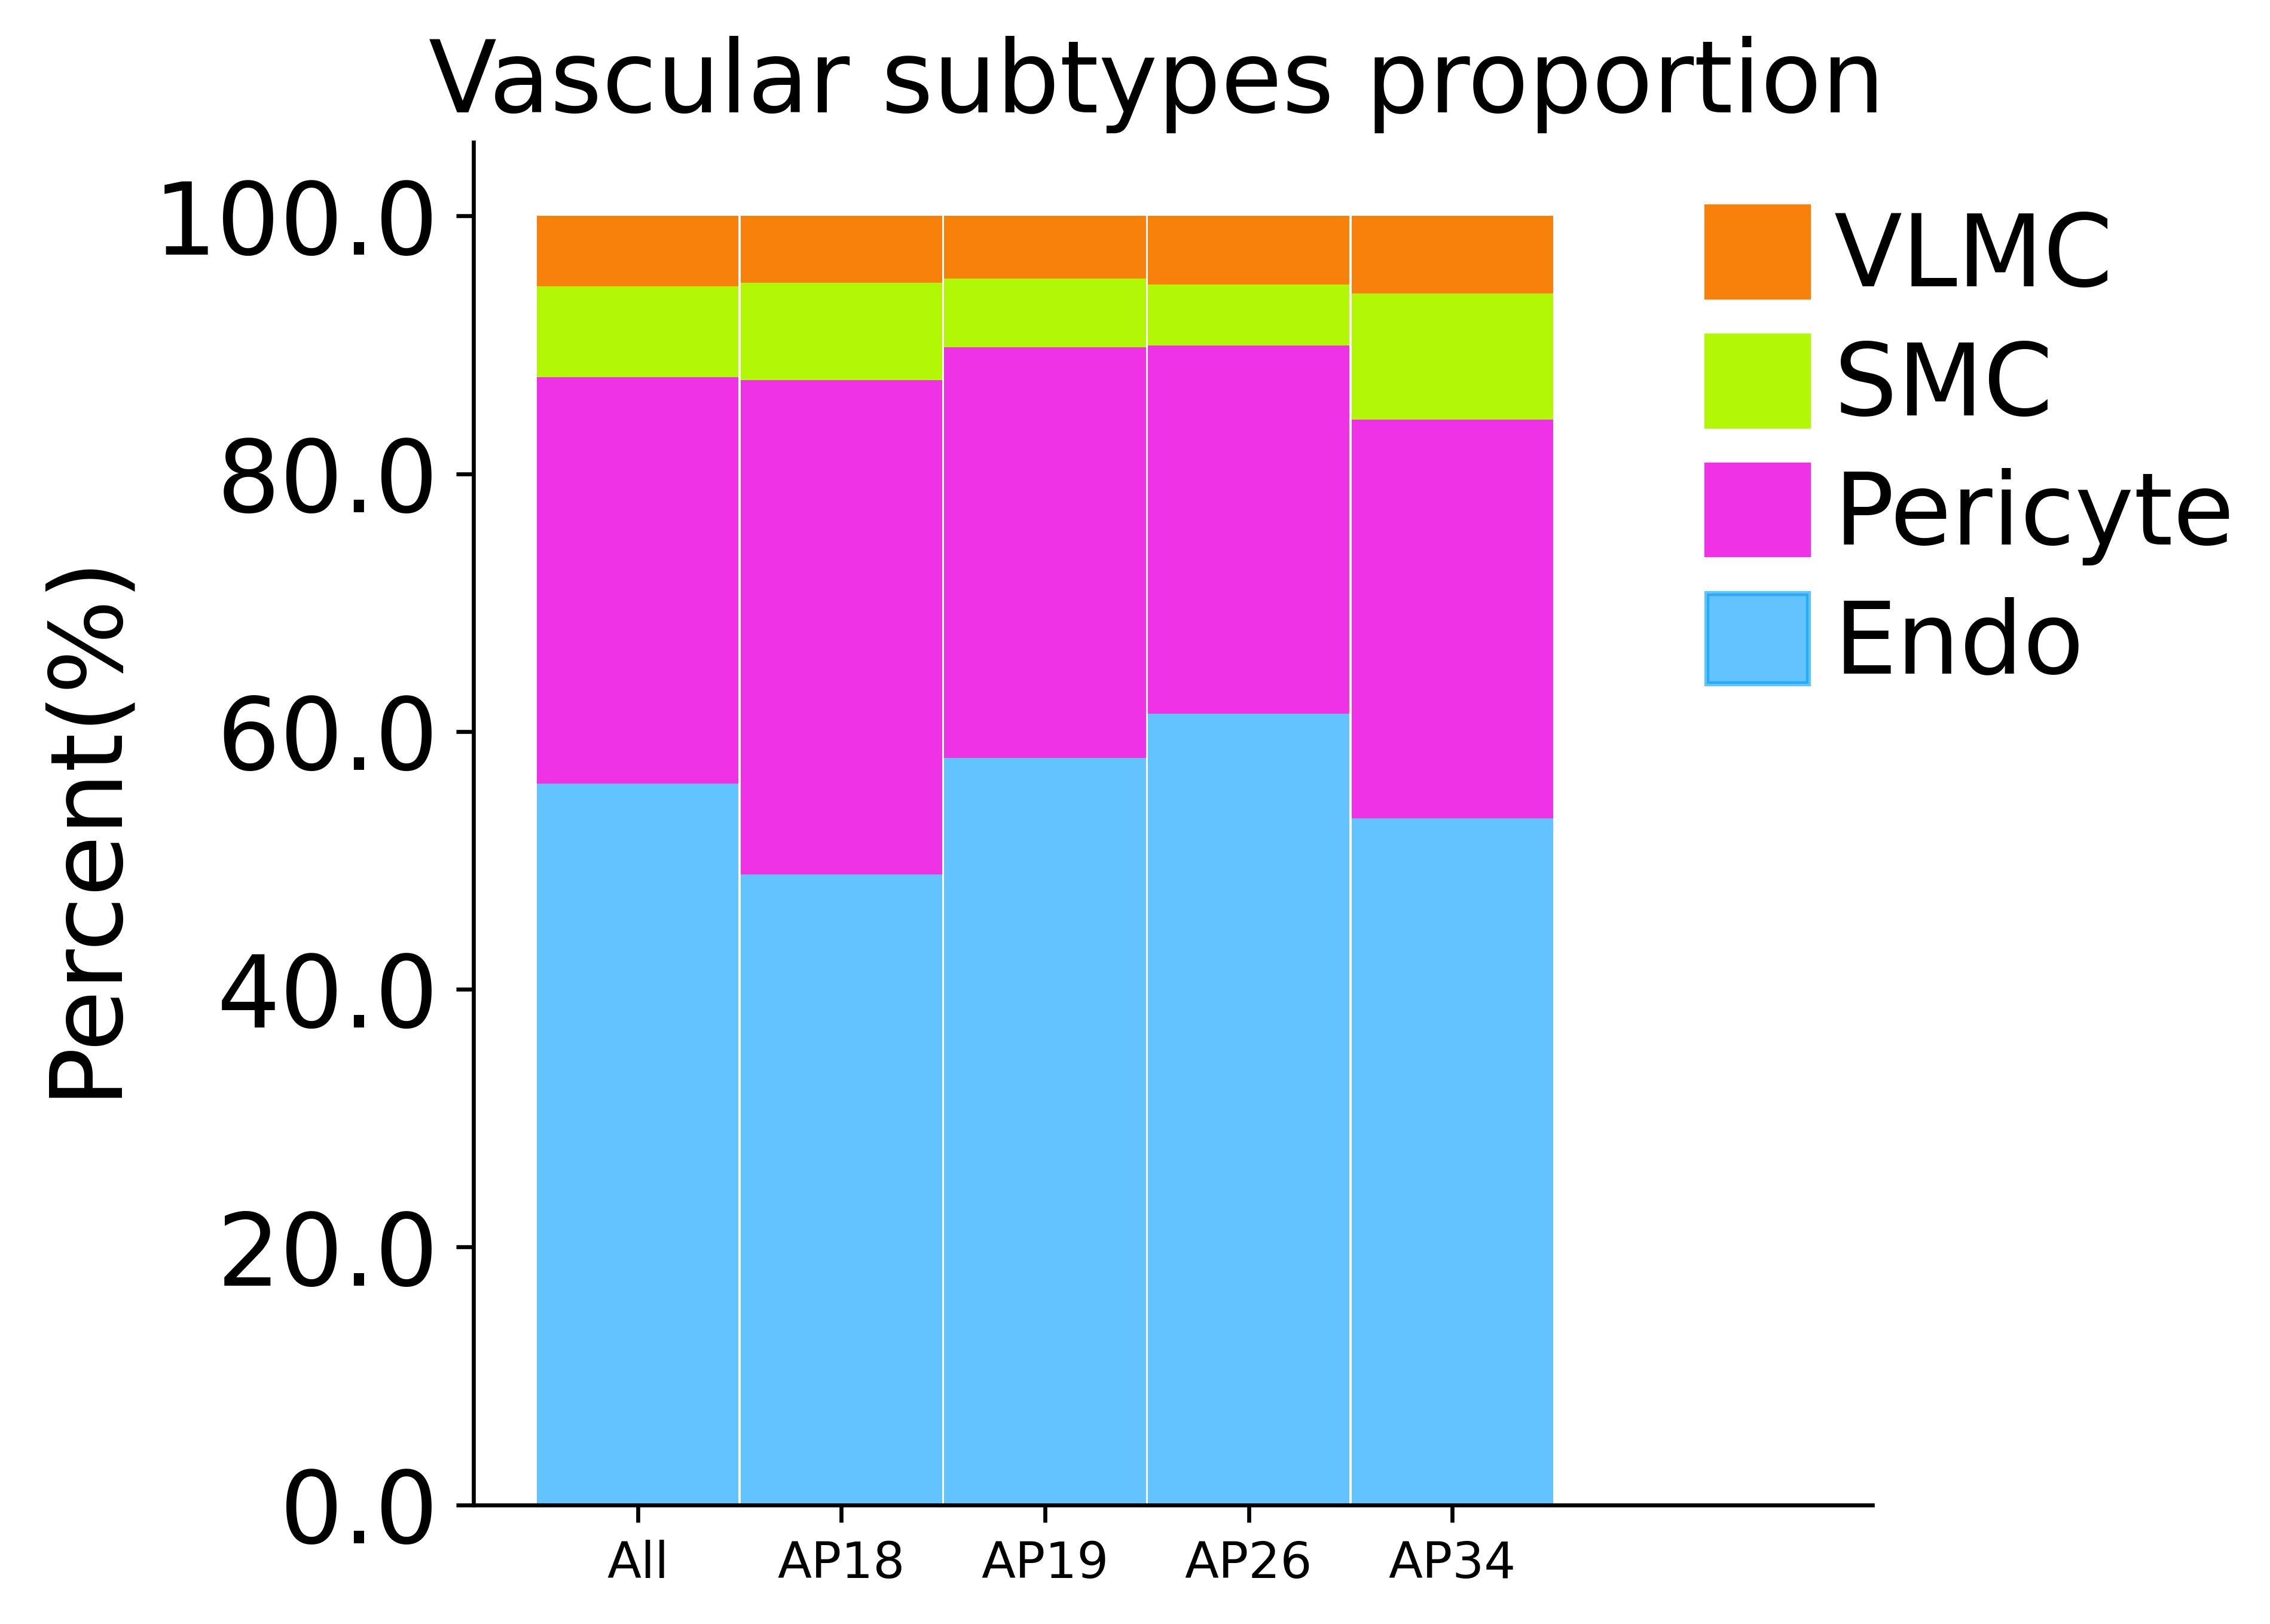

In [15]:
# first get the overall proporition
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
adata_obs = adata_MERFISH.obs.copy()
keeptype = adata_obs['Class_name'].isin(['Vascular'])
adata_obs = adata_obs[keeptype].copy()

# # remove unused cell types,
celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
for nm in celltype_cols:
    adata_obs[nm] = adata_obs[nm].astype(str)
    adata_obs[nm] = adata_obs[nm].astype('category')
vascular_fraction = [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':'All'})]

# then get the per sample proporition 
for sample in ['Donor_3924_anterior','Donor_2724_anterior','Donor_2724_posterior','Donor_1311_posterior']: #np.unique(adata_MERFISH.obs['samples']):

    adata_obs = adata_MERFISH[adata_MERFISH.obs['samples'] == sample].obs.copy()
    keeptype = adata_obs['Class_name'].isin(['Vascular'])
    adata_obs = adata_obs[keeptype].copy()
    
    # # remove unused cell types,
    celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
    for nm in celltype_cols:
        adata_obs[nm] = adata_obs[nm].astype(str)
        adata_obs[nm] = adata_obs[nm].astype('category')
    vascular_fraction += [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':sample})]

vascular_fraction = pd.concat(vascular_fraction,axis = 1)

# stacked bar plot
import matplotlib.patches as patches
import os
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
bottom = np.zeros(vascular_fraction.shape[-1])
width = 0.99
xlabels = [vascular_fraction.columns[0]] + [x.split('_')[1] + x.split('_')[2][0] for x in vascular_fraction.columns[1:]]
xlabel_mapper = {'3924a':'AP18','2724a':'AP19','2724p':'AP26','1311p':'AP34'}
xlabels = xlabels[:1] + [xlabel_mapper[nm] for nm in xlabels[1:]]
for idx,type_ in enumerate(vascular_fraction.index):
    vals = vascular_fraction.loc[type_,:].values
    ax.bar(xlabels,vals,width = width ,bottom = bottom, color =cluster_cmap[type_])
    bottom += vals

ax.grid(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.set_xticks([])
ax.set_ylabel('Percent(%)', fontdict={'fontsize': 20})

ax.tick_params('y',which='major',labelsize = 20)
ax.tick_params('x',which='major',labelsize = 10)
# add legend 
bbox = ax.get_position()
for i,type_ in enumerate(vascular_fraction.index):
    rec = patches.Rectangle([bbox.xmin +  6.5*bbox.width , 0.7*bbox.ymax + i* 0.1] , 0.5,0.07, color = cluster_cmap[type_], )
    ax.add_patch(rec)

    # add label 
    ax.text(bbox.xmin +  7.3*bbox.width , (0.7*bbox.ymax + i* 0.1) + 0.03,type_,va = 'center')
yticks = ax.get_yticks()
ax.set_yticklabels([np.round(100*y) for y in yticks])
ax.set_title(f'Vascular subtypes proportion ', fontdict={'fontsize': 20})
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot__Vascular_CellType_proportion' + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_Vascular_CellType_proportion' + '.tif',bbox_inches = 'tight')
plt.show()

E. Proporition of immune cell types

/tmp/ipykernel_3573190/2121469221.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([np.round(100*y) for y in yticks])


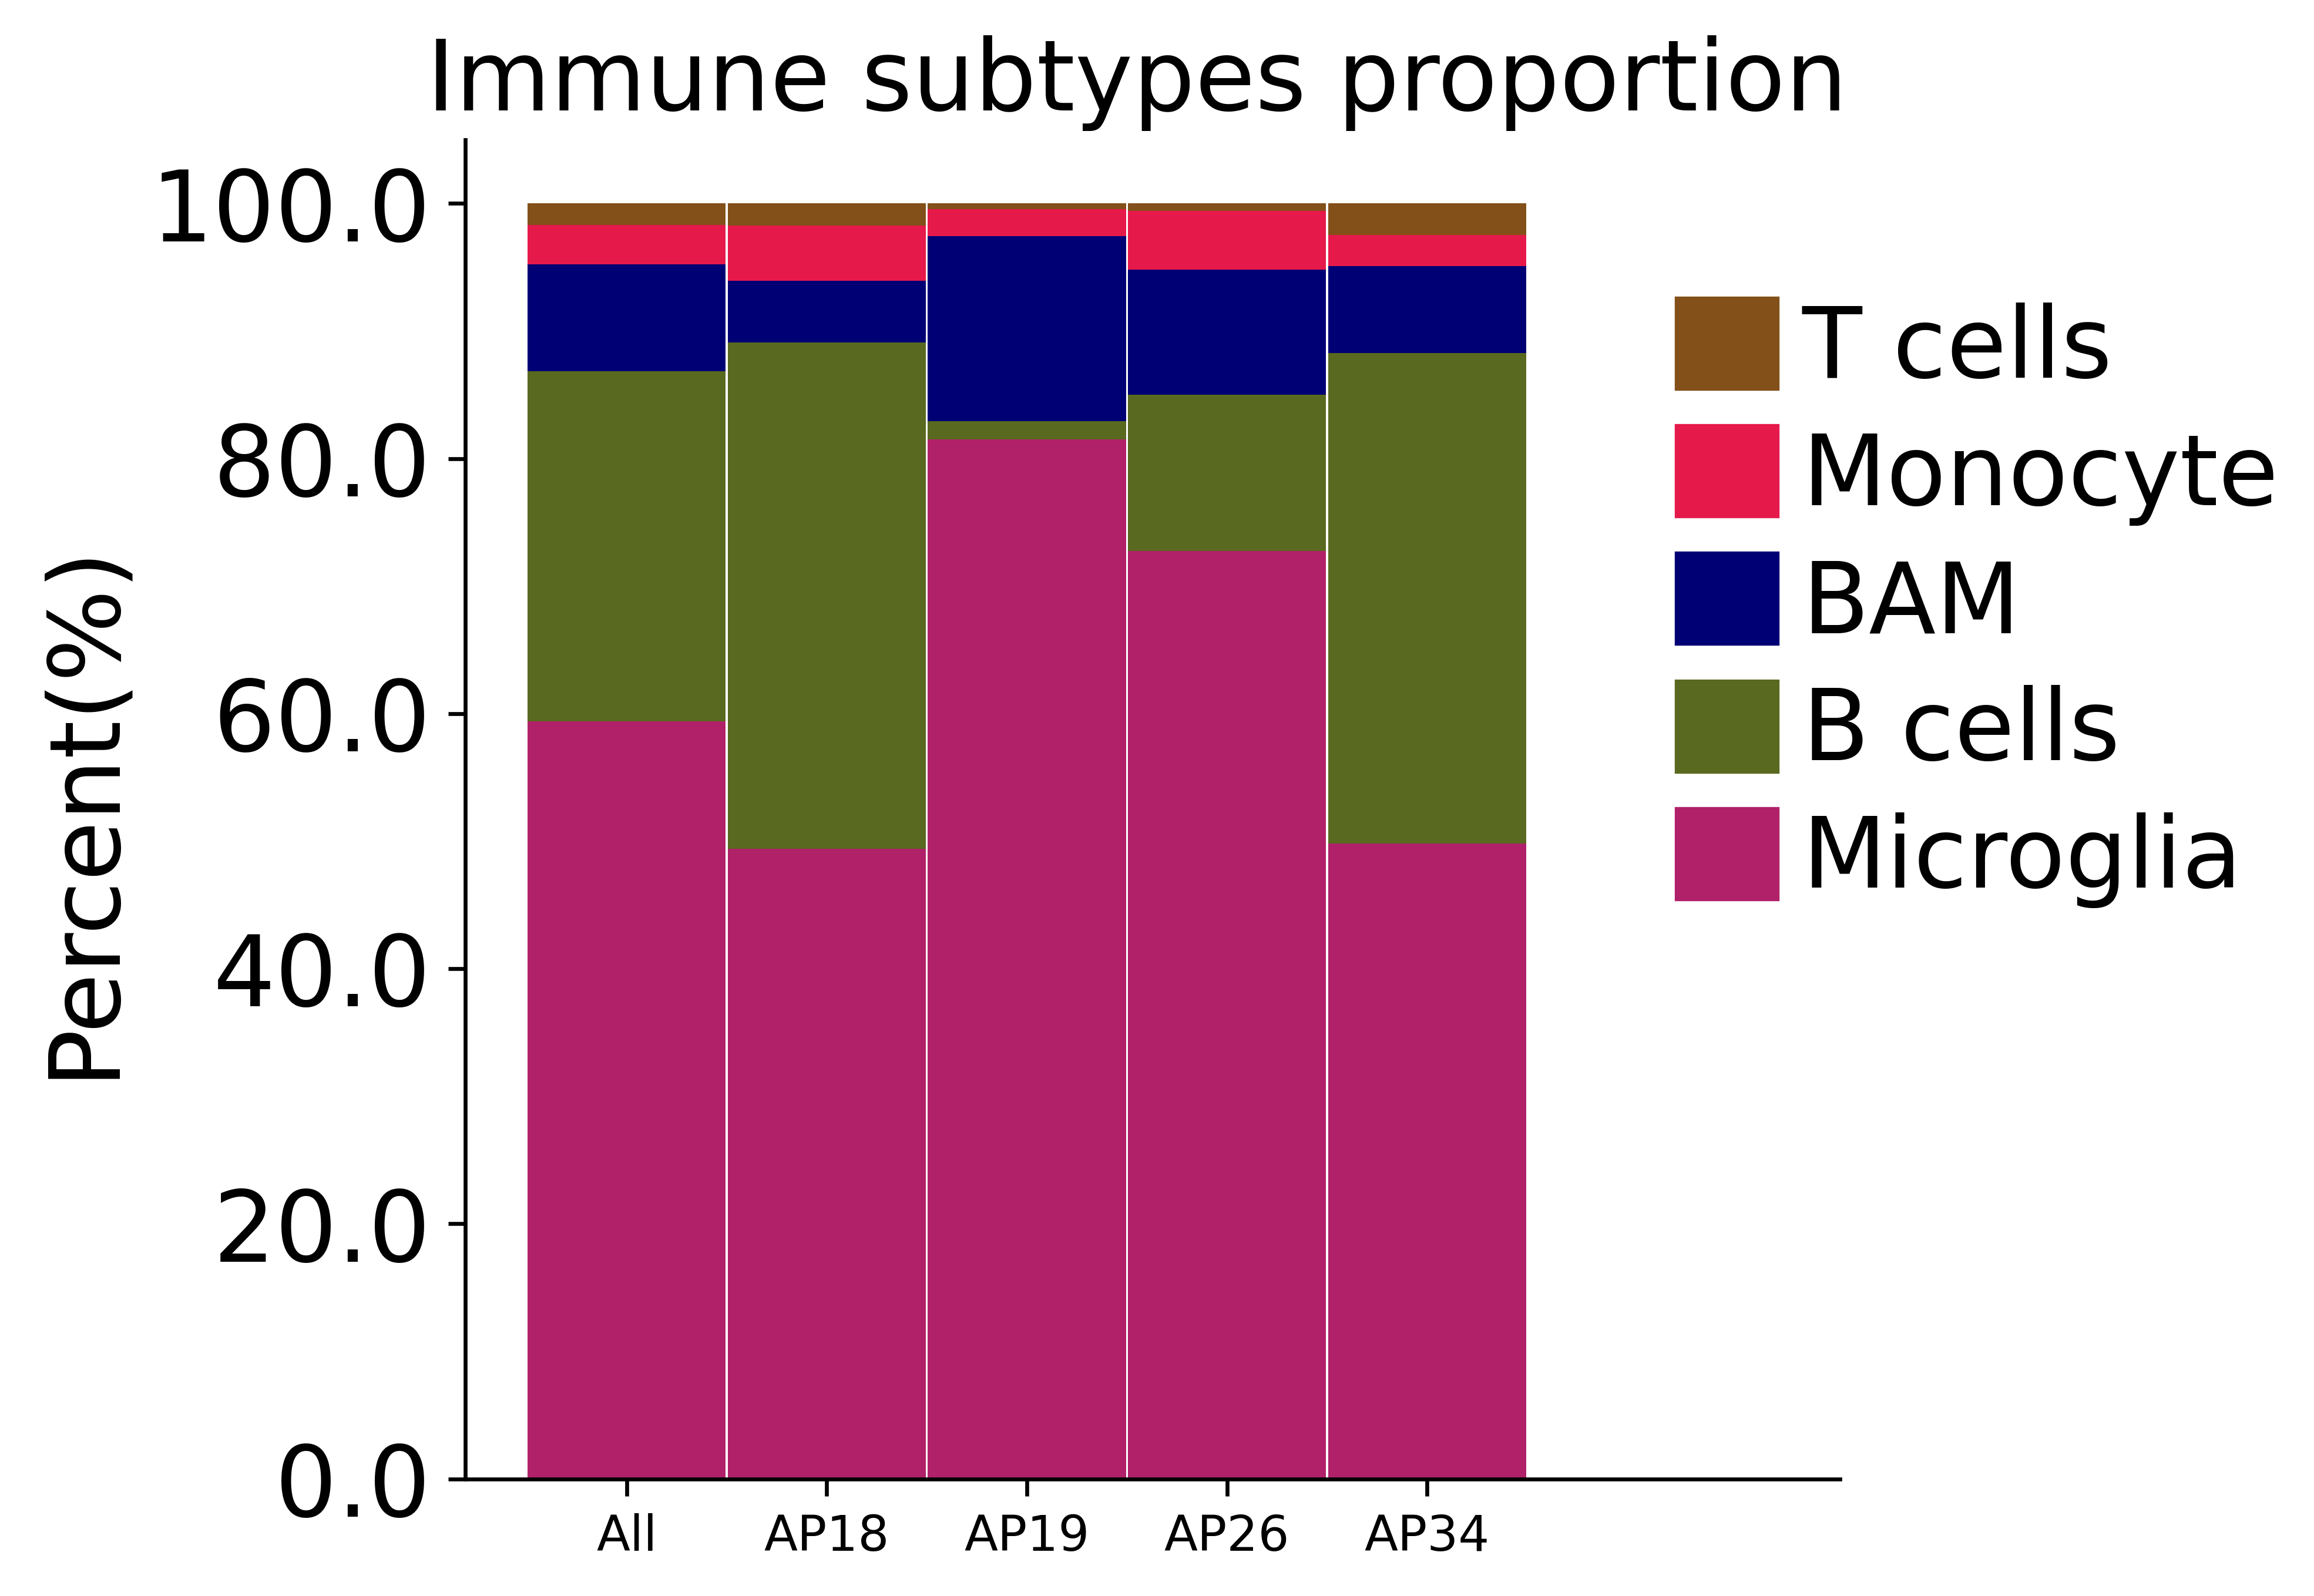

In [16]:
# first get the overall proporition
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
adata_obs = adata_MERFISH.obs.copy()
keeptype = adata_obs['Class_name'].isin(['Immune'])
adata_obs = adata_obs[keeptype].copy()

# # remove unused cell types,
celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
for nm in celltype_cols:
    adata_obs[nm] = adata_obs[nm].astype(str)
    adata_obs[nm] = adata_obs[nm].astype('category')
immune_fraction = [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':'All'})]

# then get the per sample proporition 
for sample in ['Donor_3924_anterior','Donor_2724_anterior','Donor_2724_posterior','Donor_1311_posterior']: #np.unique(adata_MERFISH.obs['samples']):

    adata_obs = adata_MERFISH[adata_MERFISH.obs['samples'] == sample].obs.copy()
    keeptype = adata_obs['Class_name'].isin(['Immune'])
    adata_obs = adata_obs[keeptype].copy()
    
    # # remove unused cell types,
    celltype_cols = [nm for nm in adata_obs.columns if 'name' in nm.lower() ]
    for nm in celltype_cols:
        adata_obs[nm] = adata_obs[nm].astype(str)
        adata_obs[nm] = adata_obs[nm].astype('category')
    immune_fraction += [adata_obs['Group_name'].value_counts(normalize = True).to_frame().rename(columns = {'proportion':sample})]

immune_fraction = pd.concat(immune_fraction,axis = 1)
# stacked bar plot
import matplotlib.patches as patches
import os
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
bottom = np.zeros(immune_fraction.shape[-1])
width = 0.99
xlabels = [immune_fraction.columns[0]] + [x.split('_')[1] + x.split('_')[2][0] for x in immune_fraction.columns[1:]]
xlabel_mapper = {'3924a':'AP18','2724a':'AP19','2724p':'AP26','1311p':'AP34'}
xlabels = xlabels[:1] + [xlabel_mapper[nm] for nm in xlabels[1:]]
for idx,type_ in enumerate(immune_fraction.index):
    vals = immune_fraction.loc[type_,:].values
    ax.bar(xlabels,vals,width = width ,bottom = bottom, color =cluster_cmap[type_])
    bottom += vals

ax.grid(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.set_xticks([])
ax.set_ylabel('Percent(%)', fontdict={'fontsize': 20})

ax.tick_params('y',which='major',labelsize = 20)
ax.tick_params('x',which='major',labelsize = 10)
# add legend 
bbox = ax.get_position()
for i,type_ in enumerate(immune_fraction.index):
    rec = patches.Rectangle([bbox.xmin +  6.5*bbox.width , 0.5*bbox.ymax + i* 0.1] , 0.5,0.07, color = cluster_cmap[type_], )
    ax.add_patch(rec)

    # add label 
    ax.text(bbox.xmin +  7.3*bbox.width , (0.5*bbox.ymax + i* 0.1) + 0.03,type_,va = 'center')
yticks = ax.get_yticks()
ax.set_yticklabels([np.round(100*y) for y in yticks])
ax.set_title(f'Immune subtypes proportion ', fontdict={'fontsize': 20})
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot__immune_CellType_proportion' + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure4/supplemental/celltype_proportion' + os.sep + f'concatenated_stackedbarplot_immune_CellType_proportion' + '.tif',bbox_inches = 'tight')
plt.show()